In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,normalize,MinMaxScaler,Normalizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import seaborn as sns
%matplotlib inline
import scipy as sp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations
from IPython.display import display, HTML
from dtreeviz.trees import dtreeviz


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/higgs-boson/training.zip
/kaggle/input/higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py
/kaggle/input/higgs-boson/random_submission.zip
/kaggle/input/higgs-boson/test.zip


In [2]:
!pip install dtreeviz

     |████████████████████████████████| 60 kB 647 kB/s eta 0:00:01
  Created wheel for dtreeviz: filename=dtreeviz-1.3-py3-none-any.whl size=66638 sha256=9d2abe47968d1a44ac541b09780cd7f801095f71fcbc2836a583d0646184321f
  Stored in directory: /root/.cache/pip/wheels/9f/a6/a1/898c991294471015f13c1e5b456fb8134c1af835db4dd93a7a
Successfully built dtreeviz
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet-cu102 1.8.0.post0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.16 which is incompatible.
autogluon-core 0.1.0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.16 which is incompatible.


# **Defining two functions that are used to get a report of our datasets**

In [3]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

# **Loading and Reading Datasets**

In [4]:
#Loading train set and loading test set
train = pd.read_csv("/kaggle/input/higgs-boson/training.zip")
test = pd.read_csv("/kaggle/input/higgs-boson/test.zip")

#EventID is identifier - making it an index in both the sets
train.set_index('EventId',inplace = True)
test.set_index('EventId',inplace=True)

In [5]:
#Looking at top 5 rows in train
train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
EventId,,,,,,,,,,,,,,,,,,,,,
100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [6]:
#Looking at training set info 
tbl_report(train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (250000, 32)


,dtype,nulls,num_uniques,value_counts
DER_mass_MMC,float64,0,108338,HC
DER_mass_transverse_met_lep,float64,0,101637,HC
DER_mass_vis,float64,0,100558,HC
DER_pt_h,float64,0,115563,HC
DER_deltaeta_jet_jet,float64,0,7087,HC
DER_mass_jet_jet,float64,0,68366,HC
DER_prodeta_jet_jet,float64,0,16593,HC
DER_deltar_tau_lep,float64,0,4692,HC
DER_pt_tot,float64,0,59042,HC
DER_sum_pt,float64,0,156098,HC


In [7]:
#Looking at the numerical descriptions
train.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,158.432217,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,115.706115,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.104000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,77.550000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,120.664500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,200.478250,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [8]:
#Looking at top 5 rows in test
test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
EventId,,,,,,,,,,,,,,,,,,,,,
350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,56.018,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,132.865,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,97.600,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,94.112,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


In [9]:
#Looking at test info
tbl_report(test, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (550000, 30)


,dtype,nulls,num_uniques,value_counts
DER_mass_MMC,float64,0,152743,HC
DER_mass_transverse_met_lep,float64,0,123271,HC
DER_mass_vis,float64,0,134982,HC
DER_pt_h,float64,0,165204,HC
DER_deltaeta_jet_jet,float64,0,7487,HC
DER_mass_jet_jet,float64,0,140826,HC
DER_prodeta_jet_jet,float64,0,20258,HC
DER_deltar_tau_lep,float64,0,4900,HC
DER_pt_tot,float64,0,76134,HC
DER_sum_pt,float64,0,241132,HC


In [10]:
#Looking at statistical description of test
test.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,...,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000
mean,-48.950144,49.261093,81.123904,57.824801,-707.448878,-599.705905,-708.391425,2.374076,18.988277,158.659749,...,-0.008214,209.933695,0.980171,-348.946684,-399.883839,-399.896234,-691.309277,-708.150605,-708.153058,73.248856
std,406.233686,35.425422,40.435560,63.291314,454.928791,659.129589,453.461222,0.779895,21.767376,116.237589,...,1.812777,126.910079,0.979271,533.155176,489.467786,489.457747,480.435230,453.834190,453.830095,98.467134
min,-999.000000,0.000000,6.810000,0.000000,-999.000000,-999.000000,-999.000000,0.237000,0.000000,46.103000,...,-3.142000,13.847000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000
25%,78.167750,19.313000,59.422000,14.192000,-999.000000,-999.000000,-999.000000,1.815000,2.838000,77.471000,...,-1.574000,122.984750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,105.076000,46.455500,73.747000,38.469500,-999.000000,-999.000000,-999.000000,2.492000,12.390000,120.701500,...,-0.017000,179.949000,1.000000,38.970000,-1.862000,-2.111000,-999.000000,-999.000000,-999.000000,40.503500
75%,130.769000,73.646000,92.173000,79.234250,0.503000,84.266250,-4.538000,2.962000,27.649000,201.018000,...,1.558000,263.917250,2.000000,75.499000,0.431000,0.484000,33.832000,-2.429000,-2.260000,110.507000
max,1949.261000,968.669000,1264.965000,1337.187000,8.724000,4794.827000,17.294000,5.751000,759.363000,2079.162000,...,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000


# **Exploratory Data Analysis**


## Let us look at the Class Ratio in our dataset.

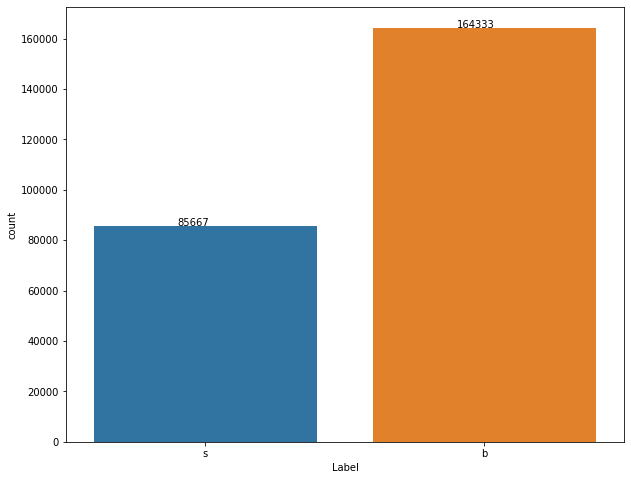

In [11]:
#Let's see the count of each class in our label
plt.figure(figsize=(10,8))
ax = sns.countplot(train['Label']);
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+5));

Looks like we do indeed have an imbalanced dataset. Considering this, accuracy would not be a good metric of performance. F1 score would be a better fit.

## Finding distribution of each Feature

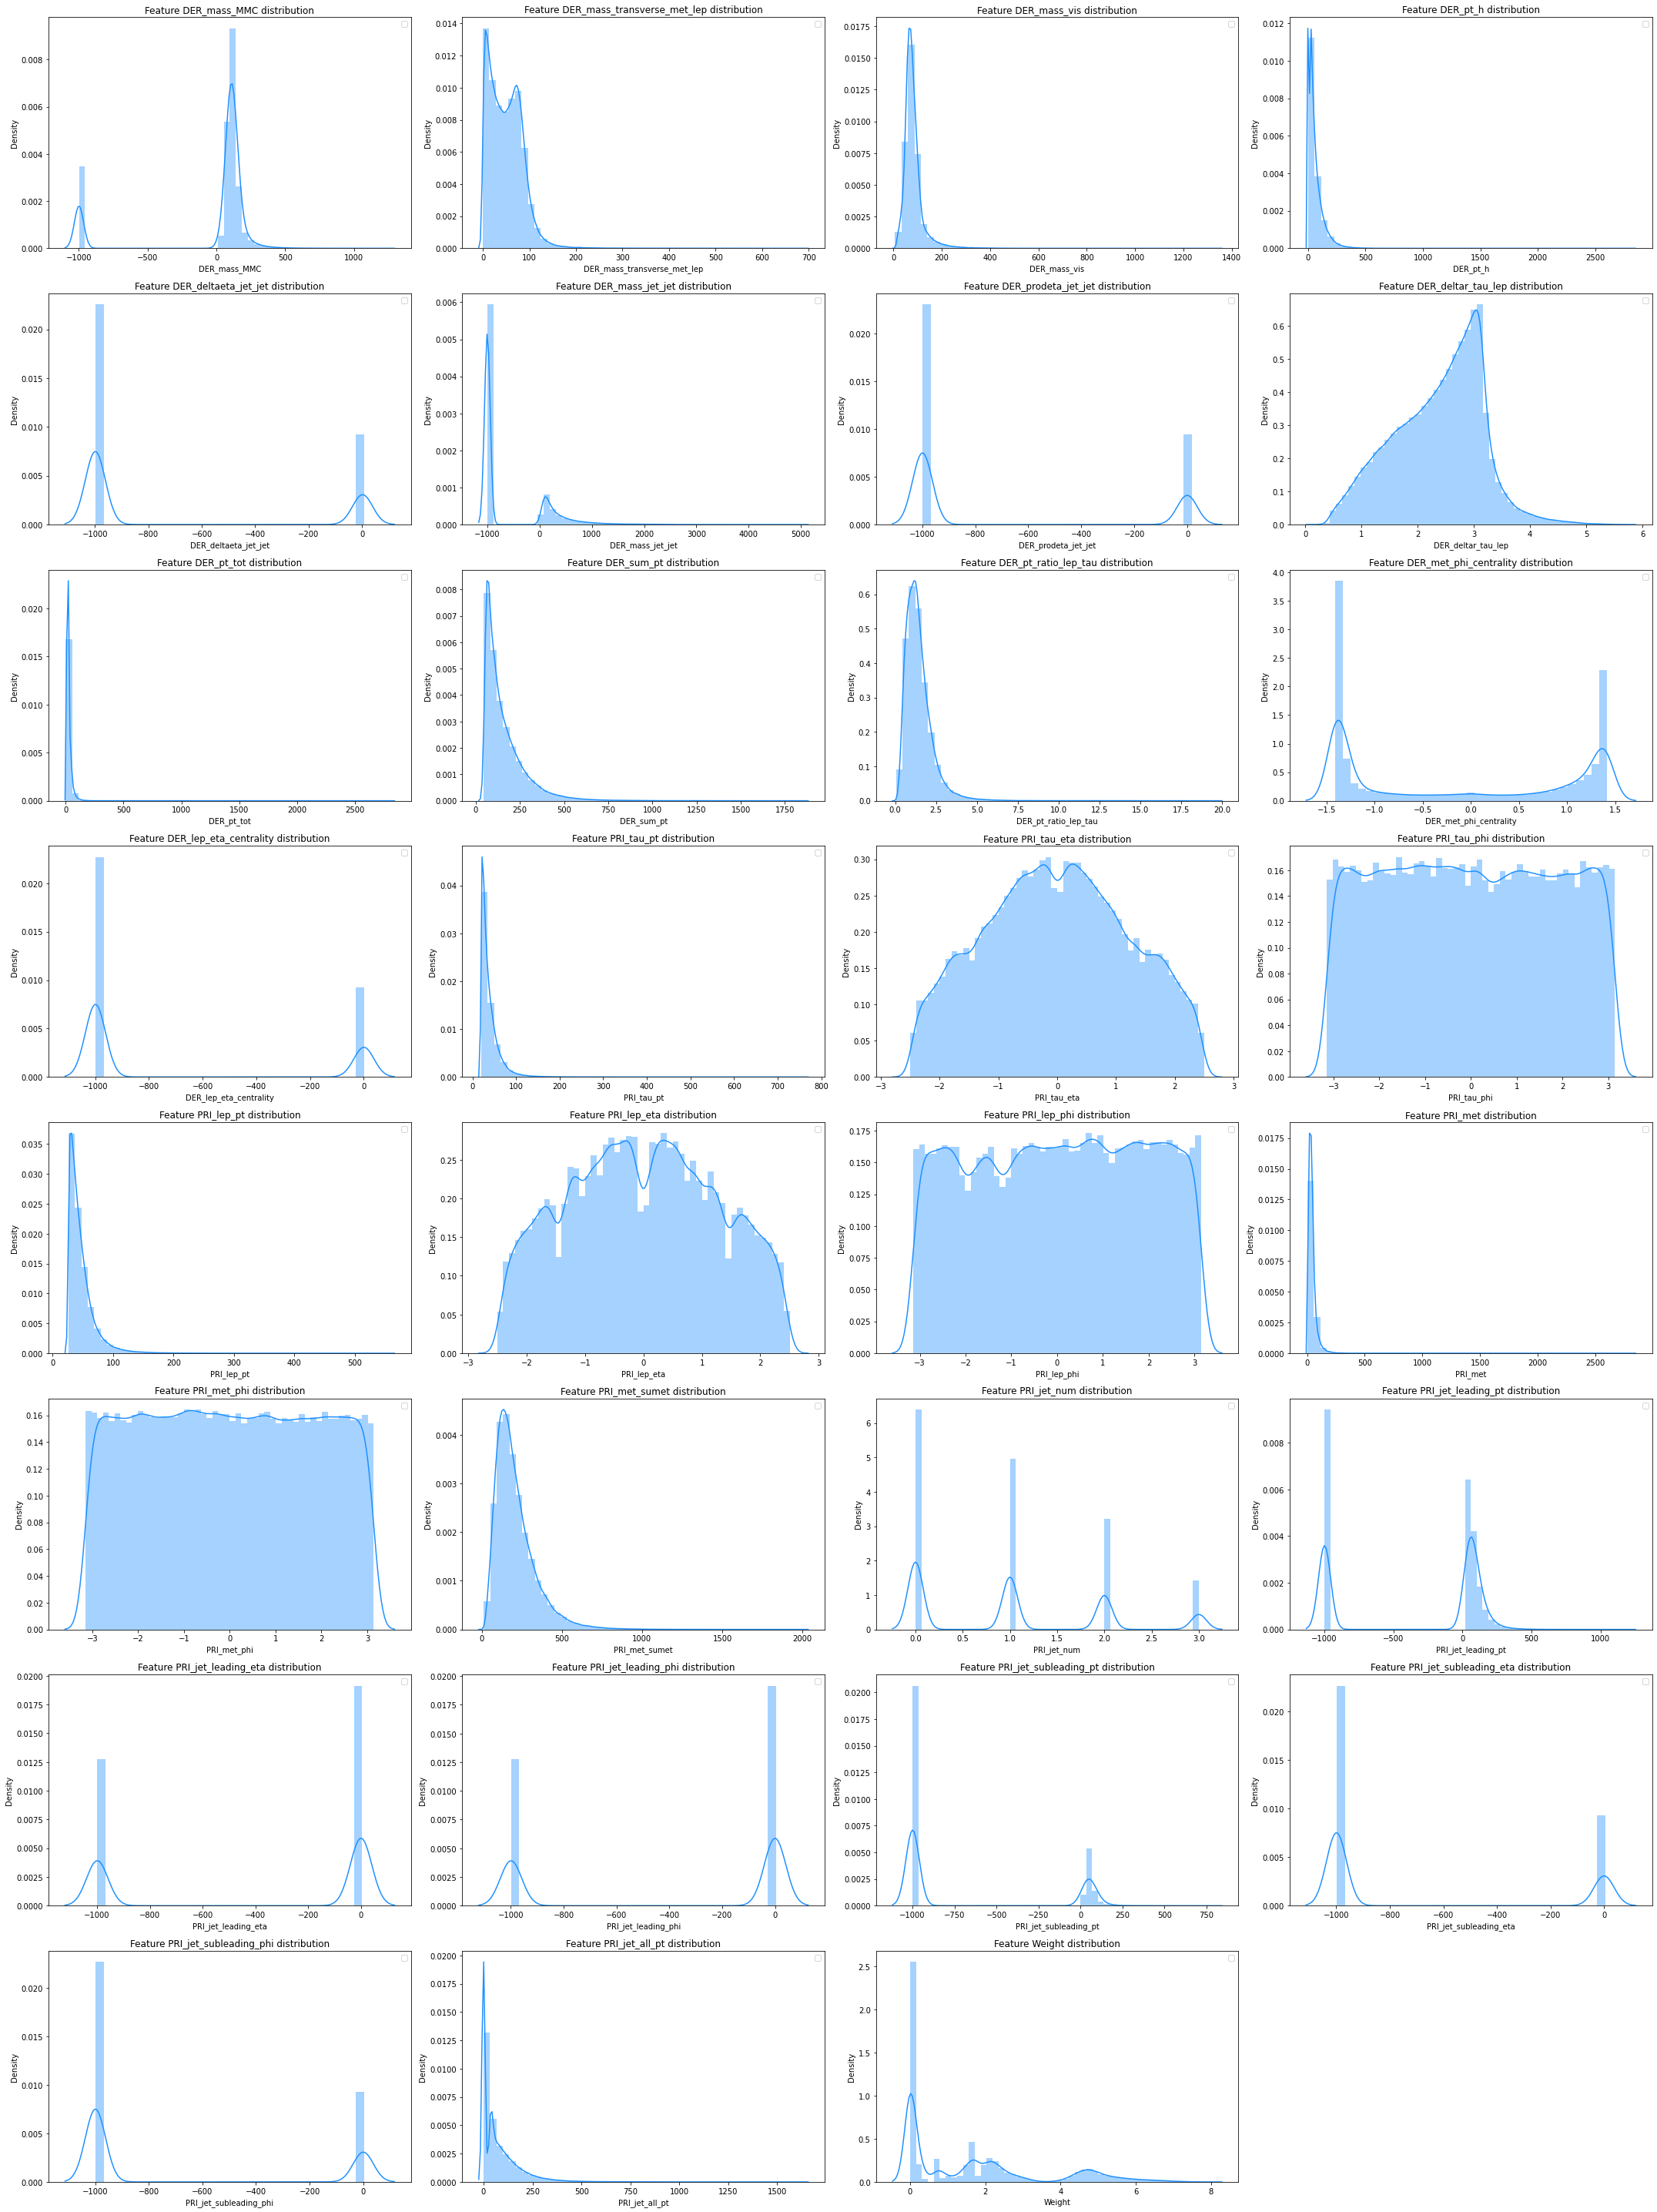

In [12]:
#Plotting Distribution of each feature
fig=plt.figure(figsize=(30,40))

for i in range(np.shape(train)[1]-1):
    ax = fig.add_subplot(8,4,i+1)
    ax = sns.distplot(train.iloc[:,i], color = 'dodgerblue')
    ax.set_title("Feature "+ train.columns[i] +" distribution")
    ax.legend()
fig.tight_layout();

## **Univariate Analysis**

### Finding the distribution of Data Per Class

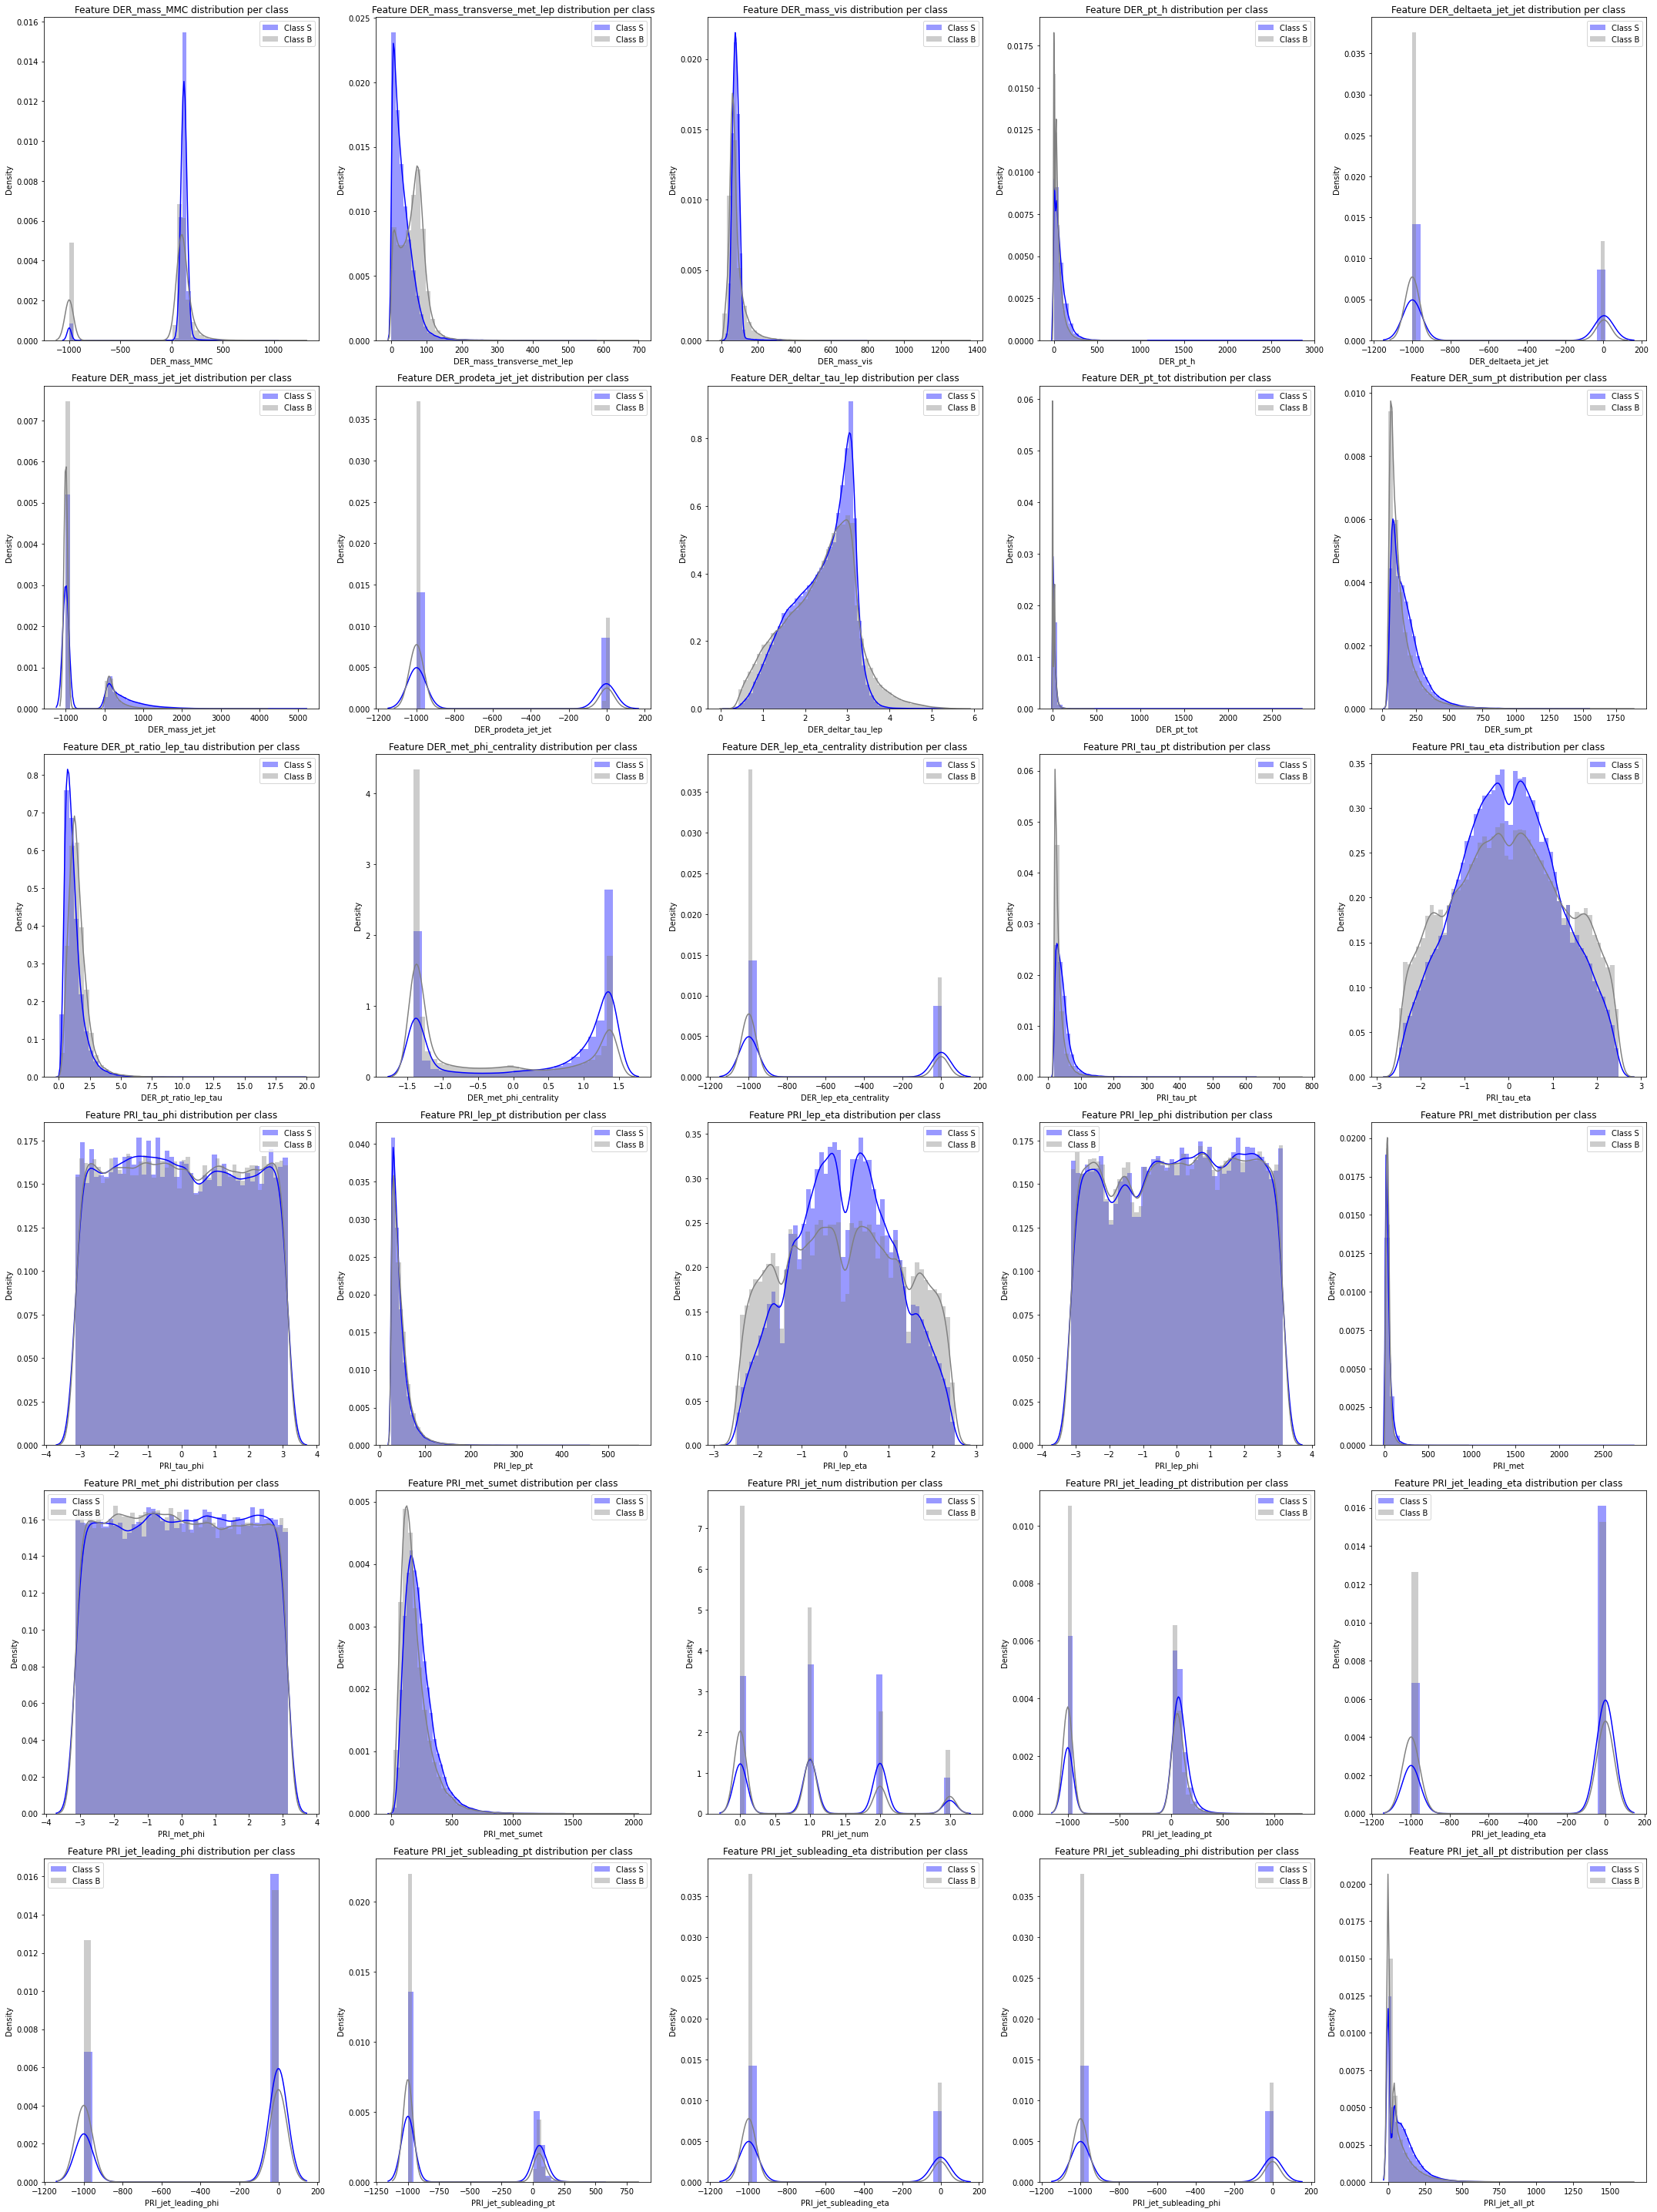

In [13]:
#Plotting Distribution of features per class
fig=plt.figure(figsize=(30,40))

for i in range(np.shape(train)[1]-2):
    ax = fig.add_subplot(6,5,i+1)
    ax = sns.distplot(train[train['Label'] == 's'].iloc[:,i],label="Class S", color = "blue")
    ax = sns.distplot(train[train['Label'] == 'b'].iloc[:,i],label="Class B", color = "grey")
    ax.set_title("Feature "+ train.columns[i] +" distribution per class")
    ax.legend()
fig.tight_layout();

## **Bivariate Analysis**

### Finding highly correlated Features - and printing the pairs of highly correlated features with threshold of 0.85

In [14]:
train.corr().style.background_gradient(cmap='Blues')

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
DER_mass_MMC,1.000000,-0.455755,0.168548,0.198765,0.162661,0.160524,0.162521,0.228105,0.045826,0.201464,-0.017073,0.358963,0.162623,0.131495,0.002579,-0.006177,0.099445,0.010060,-0.000744,-0.233724,0.007411,0.221984,0.221078,0.250158,0.247083,0.247078,0.162836,0.162614,0.162609,0.185372,-0.327244
DER_mass_transverse_met_lep,-0.455755,1.000000,0.190109,-0.249116,-0.176386,-0.190392,-0.175942,0.043251,0.017758,-0.146837,0.349504,-0.419757,-0.176262,-0.145464,-0.002109,0.001132,0.310648,-0.006777,0.000340,0.183716,-0.015925,-0.167811,-0.210537,-0.229674,-0.220370,-0.220355,-0.176837,-0.176231,-0.176225,-0.210009,0.419843
DER_mass_vis,0.168548,0.190109,1.000000,-0.062562,-0.032251,-0.040620,-0.032126,0.579712,-0.000702,0.088685,0.097490,-0.090846,-0.032220,0.290011,0.002127,-0.003624,0.405482,0.002196,-0.002018,-0.087330,-0.001467,0.053300,-0.026860,-0.019151,-0.013749,-0.013742,-0.033188,-0.032202,-0.032206,-0.052902,0.102172
DER_pt_h,0.198765,-0.249116,-0.062562,1.000000,0.523664,0.534531,0.523639,-0.539379,0.310501,0.832733,0.089187,0.539356,0.523720,0.407421,0.001665,0.005248,0.360939,0.008354,-0.002923,0.679585,0.008585,0.782547,0.623401,0.621599,0.564898,0.564894,0.531647,0.523714,0.523703,0.808616,-0.414084
DER_deltaeta_jet_jet,0.162661,-0.176386,-0.032251,0.523664,1.000000,0.946045,0.999981,-0.299076,0.270878,0.671996,0.041307,0.368492,0.999998,0.188086,0.004866,0.003302,0.168039,0.008678,0.000069,0.305561,0.005245,0.619100,0.867521,0.545027,0.521657,0.521664,0.999346,0.999995,0.999996,0.712446,-0.395375
DER_mass_jet_jet,0.160524,-0.190392,-0.040620,0.534531,0.946045,1.000000,0.944443,-0.303751,0.247771,0.680700,0.027674,0.369803,0.945584,0.204106,0.003584,0.003321,0.164026,0.007602,-0.000596,0.318497,0.005167,0.617057,0.814191,0.521645,0.493233,0.493241,0.947652,0.945505,0.945507,0.719962,-0.394004
DER_prodeta_jet_jet,0.162521,-0.175942,-0.032126,0.523639,0.999981,0.944443,1.000000,-0.299083,0.271435,0.672158,0.041614,0.368177,0.999990,0.187936,0.004880,0.003309,0.168270,0.008692,0.000070,0.305678,0.005254,0.619388,0.867741,0.545022,0.521653,0.521661,0.999347,0.999988,0.999989,0.712620,-0.395004
DER_deltar_tau_lep,0.228105,0.043251,0.579712,-0.539379,-0.299076,-0.303751,-0.299083,1.000000,-0.148081,-0.432603,0.047046,-0.205441,-0.299115,-0.202035,0.003632,-0.011229,-0.069957,0.000699,-0.000776,-0.402345,-0.001570,-0.407002,-0.347904,-0.335851,-0.304161,-0.304145,-0.303416,-0.299107,-0.299101,-0.448737,0.197881
DER_pt_tot,0.045826,0.017758,-0.000702,0.310501,0.270878,0.247771,0.271435,-0.148081,1.000000,0.381160,0.039193,0.178448,0.271058,0.095754,0.003596,0.001452,0.109617,0.007987,-0.004249,0.269739,0.002515,0.448925,0.360409,0.202920,0.186564,0.186590,0.279203,0.271100,0.271091,0.403382,-0.219507
DER_sum_pt,0.201464,-0.146837,0.088685,0.832733,0.671996,0.680700,0.672158,-0.432603,0.381160,1.000000,0.108791,0.420679,0.672116,0.485847,0.002037,0.003931,0.460938,0.008781,-0.001892,0.520129,0.006712,0.904481,0.758503,0.638796,0.578616,0.578621,0.687465,0.672125,0.672114,0.965628,-0.414827


# **Creation of a Baseline Model**

In [15]:
#Splitting into X and y
X = train.drop(['Weight','Label'],axis=1)
y = pd.factorize(train['Label'])[0]

In [16]:
#Storing Categorical and Continuous Variables
cat_vars = ['PRI_jet_num']
cont_vars = np.array(train.drop(['PRI_jet_num','Weight','Label'],axis=1).columns)

## Utility Functions to make Model building and Cross-validation easier.

In [17]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf,y,score_func, n_folds=5, n_jobs=1):
    
    X = indf
    y = y
    
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,train_size=0.8,random_state=214)
    
    clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    
    clf = clf.fit(Xtrain, ytrain)
    
    training_accuracy = clf.score(Xtrain, ytrain)
    
    test_accuracy = clf.score(Xtest, ytest)
    print()
    print()
    print("############# Based On Standard Predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print()
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    print()
    
    plot_confusion_matrix(clf,Xtest,ytest,cmap="Blues")
    return clf, Xtrain, ytrain, Xtest,ytest

## Setting up Pipeline for Baseline Logistic Regression Model

In [18]:
# Set Up Normalization
normalize = Normalizer()

# Set up One Hot Encoding of Target Variable
oh = OneHotEncoder()

# Continuous Variables Neet to be normalized
cont_pipe = Pipeline([('normalize', normalize)])

# Categorical variables need to be one hot encoded
cat_pipe = Pipeline([('onehot', oh)])

# Combine both into a transformer
transformers = [('cont', cont_pipe, cont_vars), ('cat', cat_pipe, cat_vars)]

# Apply transformer to relevant columns. Nothing will be done for the rest
ct = ColumnTransformer(transformers=transformers, remainder="passthrough")

# Create a pipeline so that we are not leaking data from validation to train in the individual folds
pipe_lr = Pipeline(steps=[('ct', ct), ('model', LogisticRegression(max_iter=10000, penalty='l2'))])

# In paramgrid we dont use C but use model__C corresponding to the name in the pipeline
paramgrid_lr = dict(model__C=[1000, 100, 10, 1, 0.1, 0.01, 0.001])

Now we train our model. Our do_classify takes care of subsetting the data and pickinging up the target variable.We score using the AUC on the validation sets.

SCORE FUNC roc_auc
BEST {'model__C': 1000} 0.7878361868175844


############# Based On Standard Predict ################
Accuracy on training data: 0.71
Accuracy on test data:     0.71

[[ 4665 12441]
 [ 2108 30786]]
########################################################



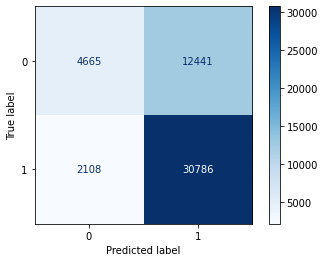

In [19]:
lr, X_train, y_train, X_test, y_test = do_classify(pipe_lr, paramgrid_lr, X, y, score_func='roc_auc')

## Setting up Pipeline for Random Forest Classifier

In [26]:
# Create a pipeline so that we are not leaking data from validation to train in the individual folds
pipe_rf = Pipeline(steps=[('ct', ct), ('rf', RandomForestClassifier())])
paramgrid_rf = { 'rf__maxfeatures': ['auto', 'sqrt'],
  'rf__maxdepth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
  'rf__min_samples_split': [2, 5, 10], 
  'rf__min_samples_leaf': [1, 2, 4],
  'rf__bootstrap': [True, False]}

rf, X_train, y_train, X_test, y_test = do_classify(pipe_rf, parameters, X, y, score_func='roc_auc')

SCORE FUNC roc_auc


ValueError: Invalid parameter max_depth for estimator Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('normalize',
                                                                   Normalizer())]),
                                                  array(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot',
       'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_me...
       'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
       'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['PRI_jet_num'])])),
                ('rf', RandomForestClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.